In [2]:
from sklearn.metrics import mean_squared_error
from sklift.metrics import uplift_auc_score
from sklift.viz import plot_uplift_curve
from catenets.models.jax import TNet, SNet1,SNet2,DRNet,RNet
from catenets.models.torch import SLearner
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from causalml.metrics import auuc_score
from sklearn.preprocessing import MinMaxScaler
from causalml.metrics import plot_gain

# Seed for reproducibility
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Load dataset
training_path = "/data/home/yilingliu/MTML/experiments/MT_lift/MT_LIFT/train.csv"
testing_path = "/data/home/yilingliu/MTML/experiments/MT_lift/MT_LIFT/test.csv"

training_data = pd.read_csv(training_path)
testing_data = pd.read_csv(testing_path)

# Convert all non-zero treatment values to 1
training_data["treatment"] = (training_data["treatment"] != 0).astype(int)
testing_data["treatment"] = (testing_data["treatment"] != 0).astype(int)

# Preprocess data
X_train = training_data.drop(columns=["click", "conversion", "treatment"]).values
X_test = testing_data.drop(columns=["click", "conversion", "treatment"]).values
A_train = training_data["treatment"].values
A_test = testing_data["treatment"].values
Y_train = training_data["click"].values
Y_test = testing_data["click"].values
C_train = training_data["conversion"].values
C_test = testing_data["conversion"].values

In [4]:
# Normalize X to (0, 1) range using training data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)  # Fit on training data and transform it
X_test_normalized = scaler.transform(X_test)        # Apply the same transformation to test data

In [24]:
def evaluate_AUUC(seed, learner_cls, n_iter, batch_size):
    """
    Evaluates AUUC predictions using a specified learner, and plots results.

    Parameters:
        seed (int): Random seed for reproducibility.
        learner_cls: Class of the learner to be used for CATE estimation.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    print("Instantiate and train the learner for Y")
    if learner_cls.__name__ == 'SLearner':
        model_y = learner_cls(n_unit_in=99, binary_y=True,n_iter=n_iter, batch_size=batch_size)
    else:
        model_y = learner_cls(binary_y=True, n_iter=n_iter, batch_size=batch_size)
    
    #model_y = learner_cls(n_iter=n_iter, batch_size=batch_size)
    model_y.fit(X=X_train_normalized, y=Y_train, w=A_train)
    uplift_visit = model_y.predict(X_test_normalized)  # predict uplift score for Y (visit)
    #auuc_visit = uplift_auc_score(Y_test, uplift_visit, A_test)
    #print("AUUC for visit (Y) from sklift\n", auuc_visit)
    if learner_cls.__name__ == 'SLearner':
        uplift_visit = uplift_visit.cpu().detach().numpy()
        
    data = {
        'treatment': A_test.ravel(),
        'outcome': Y_test.ravel(),
        'uplift_score': uplift_visit.ravel()
    }
    df = pd.DataFrame(data)
    # Calculate AUUC
    auuc = auuc_score(df, outcome_col='outcome', treatment_col='treatment', score_col='uplift_score',normalize=True)
    print("AUUC for visit (Y) from causalML\n",auuc)

    plot_gain(
        df, 
        outcome_col='outcome', 
        treatment_col='treatment', 
        #treatment_effect_col='uplift_score',
        normalize=False,
        figsize=(8,6)
    )

    print("Instantiate and train the learner for C")
    
    if learner_cls.__name__ == 'SLearner':
        model_c = learner_cls(n_unit_in=99, binary_y=True, n_iter=n_iter, batch_size=batch_size)
    else:
        model_c = learner_cls(binary_y=True, n_iter=n_iter, batch_size=batch_size)
            
    #model_c = learner_cls(n_iter=n_iter, batch_size=batch_size)
    model_c.fit(X=X_train_normalized, y=C_train, w=A_train)
    uplift_conversion = model_c.predict(X_test_normalized)  # predict uplift score for C (conversion) 
    # Compute AUUC for the uplift scores predicted by model_y and model_c
    #auuc_conversion = uplift_auc_score(C_test, uplift_conversion, A_test)
    #print("AUUC for conversion (C) from sklift\n", auuc_conversion)
    if learner_cls.__name__ == 'SLearner':
        uplift_conversion = uplift_conversion.cpu().detach().numpy()
    
    data = {
        'treatment': A_test.ravel(),
        'outcome': C_test.ravel(),
        'uplift_score': uplift_conversion.ravel()
    }
    df = pd.DataFrame(data)
    # Calculate AUUC
    auuc = auuc_score(df, outcome_col='outcome', treatment_col='treatment', score_col='uplift_score',normalize=True)
    print("AUUC for visit (C) from causalML\n",auuc)

    plot_gain(
        df, 
        outcome_col='outcome', 
        treatment_col='treatment', 
        #treatment_effect_col='uplift_score',
        normalize=False,
        figsize=(8,6)
    )
    
    # Plotting uplift curves
    #uplift_disp_visit = plot_uplift_curve(Y_test, uplift_visit, A_test, perfect=False, name='Model Visit (Y)')
    #uplift_disp_visit.figure_.suptitle("Uplift curve for Visit (Y)")
    #plt.show()
    #uplift_disp_conversion = plot_uplift_curve(C_test, uplift_conversion, A_test, perfect=False, name='Model Conversion (C)')
    #uplift_disp_conversion.figure_.suptitle("Uplift curve for Conversion (C)")
    #plt.show()

## S-learner

Instantiate and train the learner for Y
AUUC for visit (Y) from causalML
 uplift_score    0.663125
Random          0.500602
dtype: float64
Instantiate and train the learner for C
AUUC for visit (C) from causalML
 uplift_score    0.770047
Random          0.501171
dtype: float64


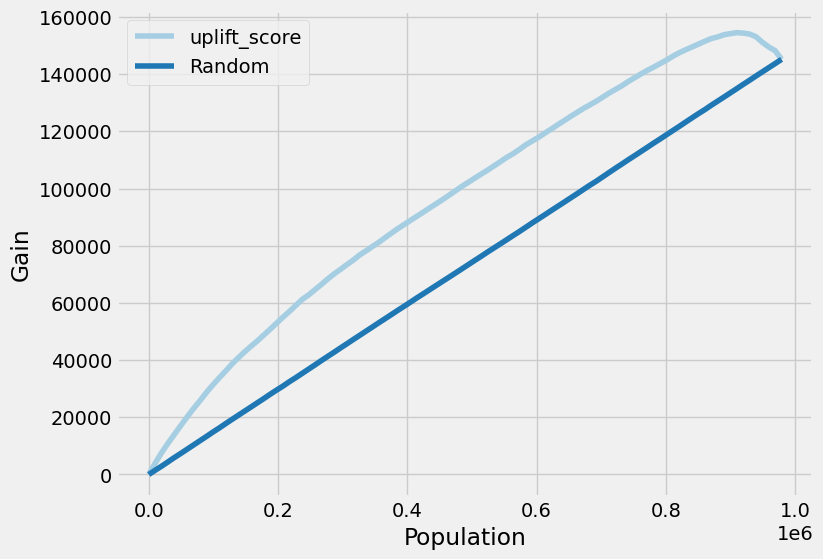

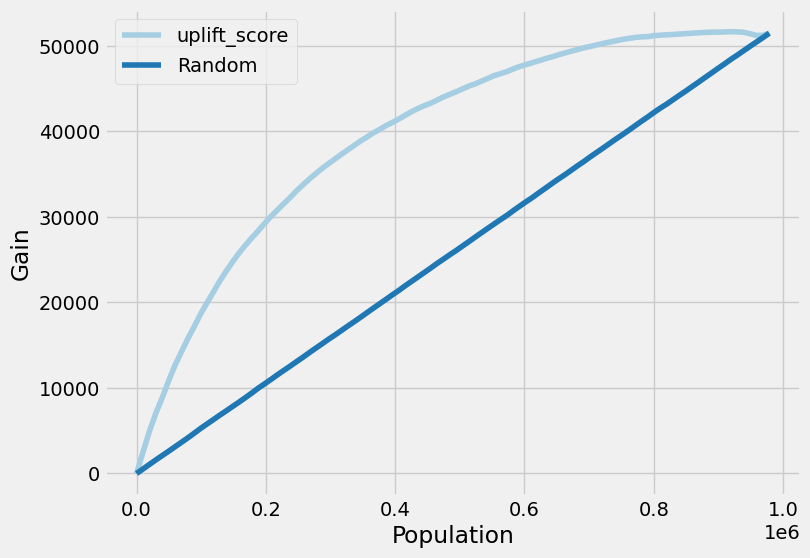

In [6]:
evaluate_AUUC(seed=123, learner_cls=SLearner,n_iter=5, batch_size=256)

## T-learner

Instantiate and train the learner for Y


2024-10-22 17:12:46.313684: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


AUUC for visit (Y) from causalML
 uplift_score    0.710909
Random          0.500602
dtype: float64
Instantiate and train the learner for C
AUUC for visit (C) from causalML
 uplift_score    0.659961
Random          0.501171
dtype: float64


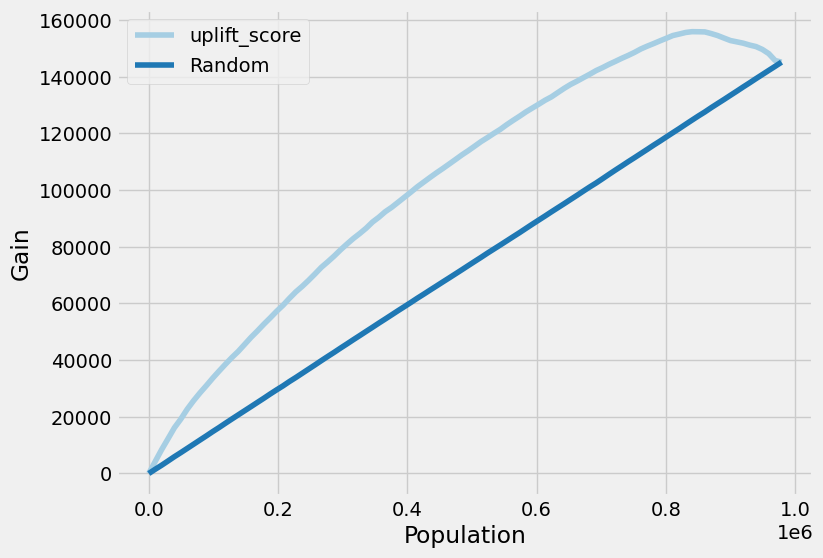

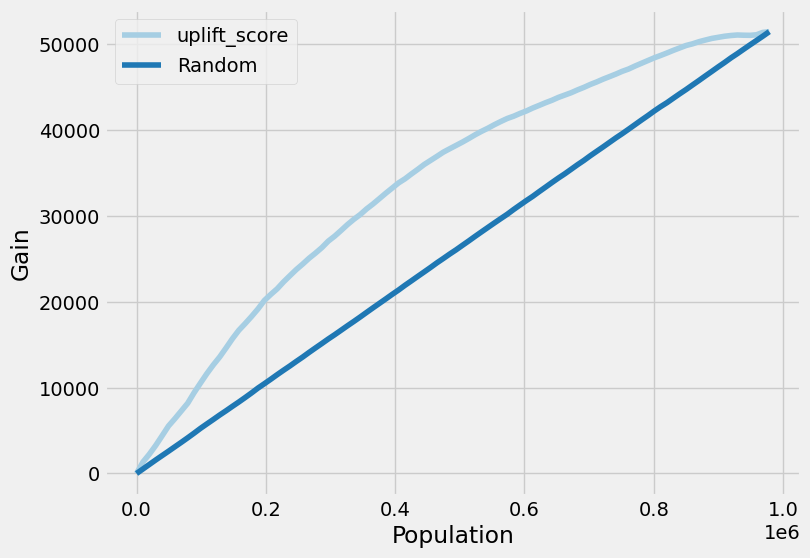

In [7]:
evaluate_AUUC(seed=123, learner_cls=TNet,n_iter=5, batch_size=256)

## R-Net

Instantiate and train the learner for Y
AUUC for visit (Y) from causalML
 uplift_score    0.501889
Random          0.500602
dtype: float64
Instantiate and train the learner for C
AUUC for visit (C) from causalML
 uplift_score    0.498306
Random          0.501171
dtype: float64


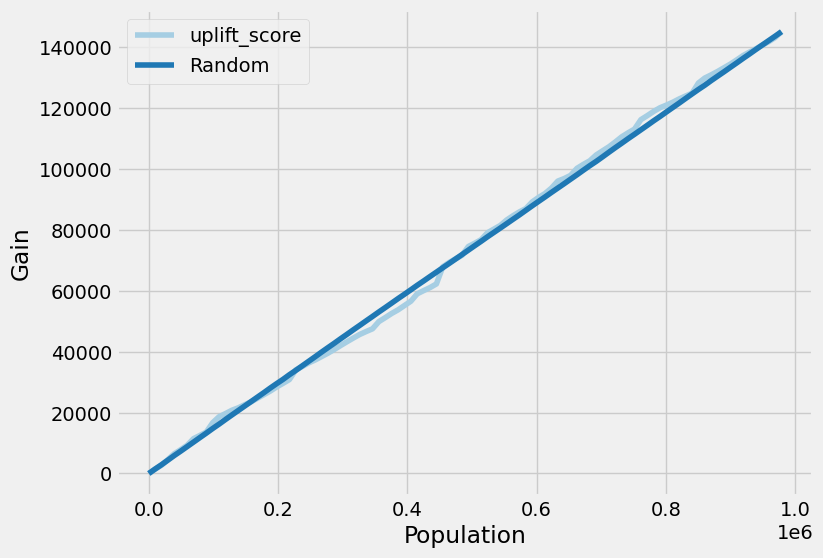

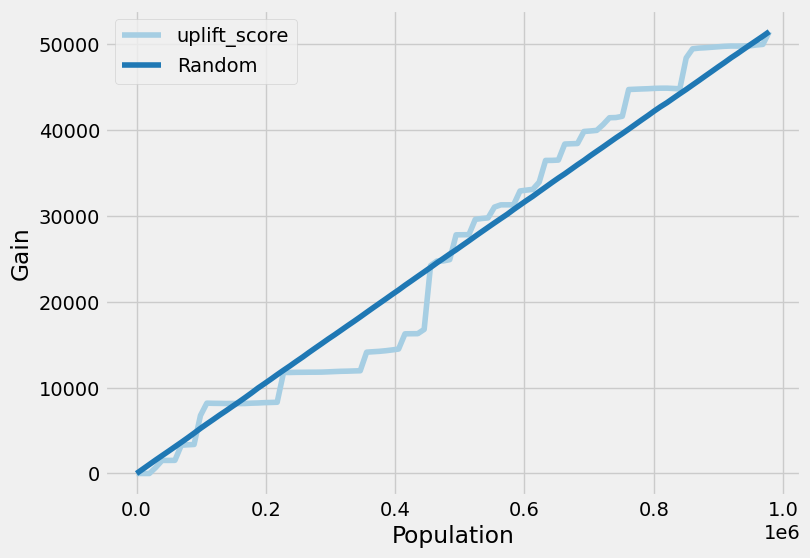

In [29]:
evaluate_AUUC(seed=123, learner_cls=RNet,n_iter=5, batch_size=256)

## TARNet

Instantiate and train the learner for Y
AUUC for visit (Y) from causalML
 uplift_score    0.590946
Random          0.500602
dtype: float64
Instantiate and train the learner for C
AUUC for visit (C) from causalML
 uplift_score    0.739798
Random          0.501171
dtype: float64


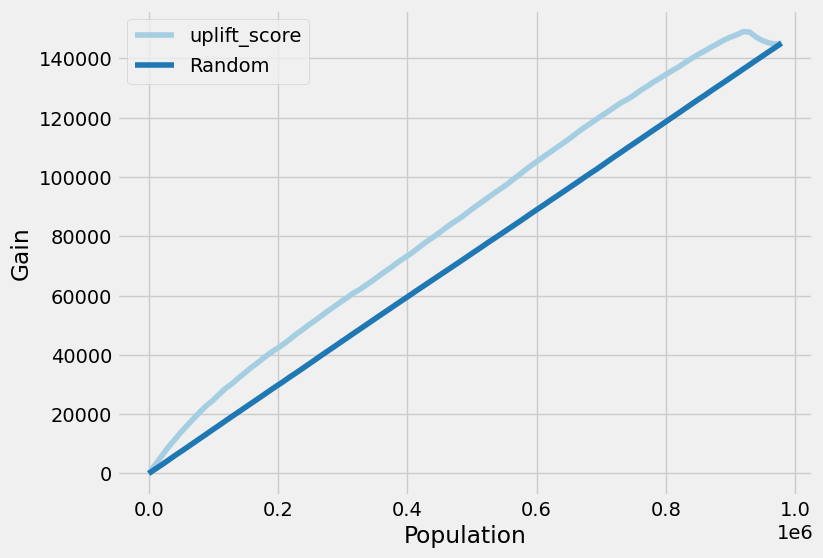

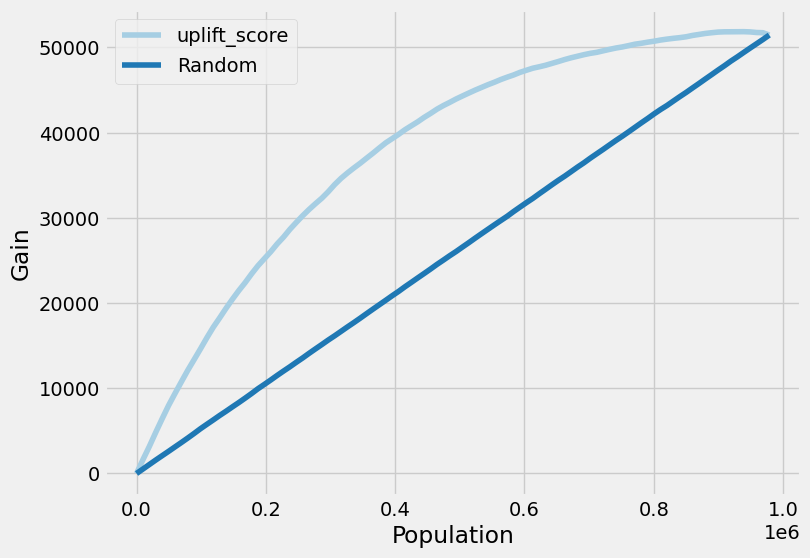

In [28]:
evaluate_AUUC(seed=123, learner_cls=SNet1,n_iter=5, batch_size=1024)

## DragonNet

Instantiate and train the learner for Y
AUUC for visit (Y) from causalML
 uplift_score    0.720345
Random          0.500602
dtype: float64
Instantiate and train the learner for C
AUUC for visit (C) from causalML
 uplift_score    0.726587
Random          0.501171
dtype: float64


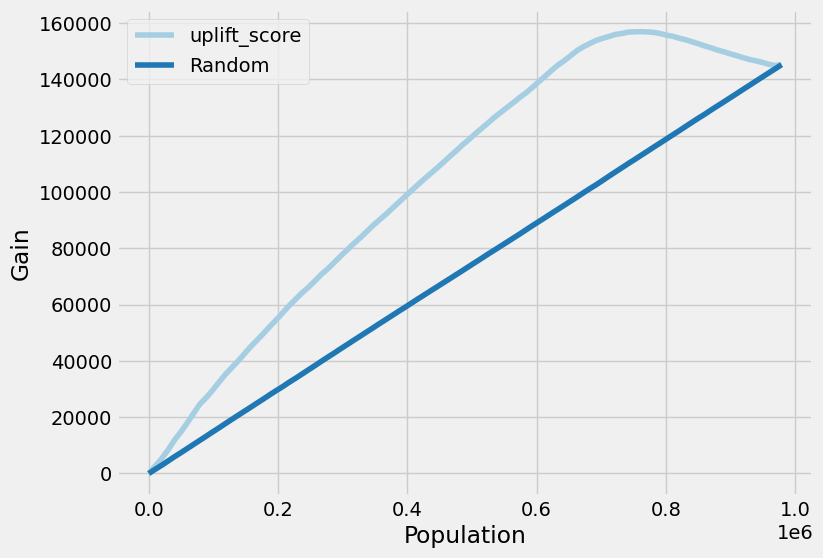

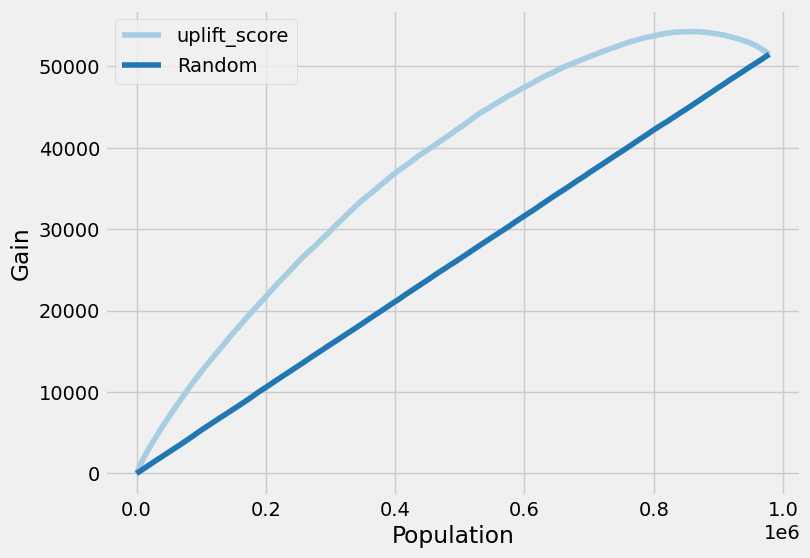

In [26]:
evaluate_AUUC(seed=123, learner_cls=SNet2,n_iter=5, batch_size=30000)

## DRNet

Instantiate and train the learner for Y
AUUC for visit (Y) from causalML
 uplift_score    0.501889
Random          0.500602
dtype: float64
Instantiate and train the learner for C
AUUC for visit (C) from causalML
 uplift_score    0.498306
Random          0.501171
dtype: float64


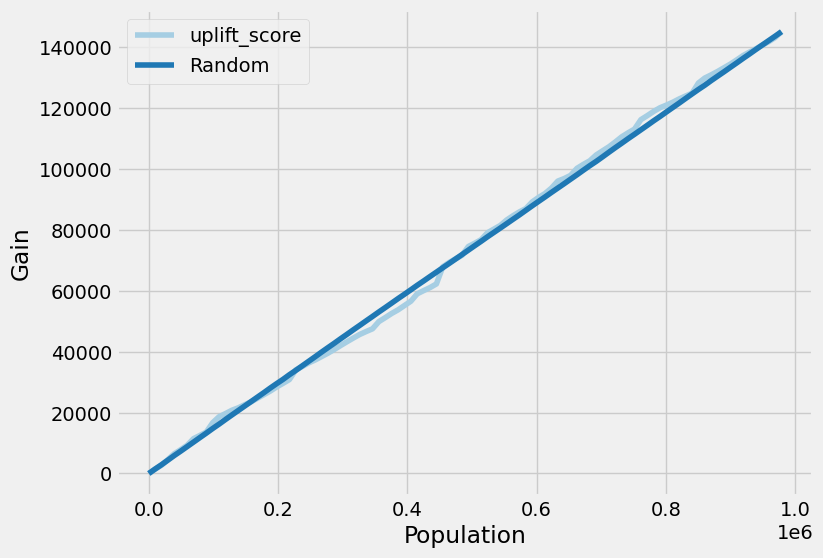

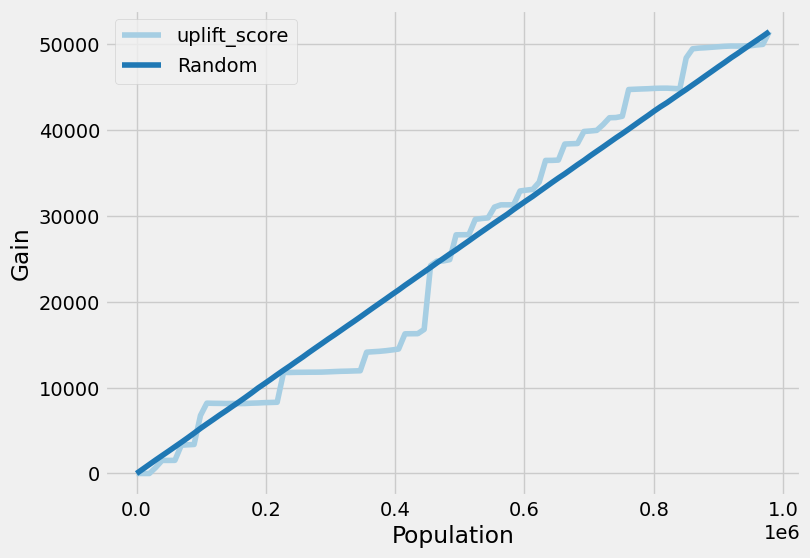

In [27]:
evaluate_AUUC(seed=123, learner_cls=DRNet,n_iter=5, batch_size=256)